In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os 
import random
from towbintools.foundation import image_handling
from towbintools.foundation import binary_image
import cv2
from scipy.ndimage import binary_fill_holes
from time import perf_counter

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import time
from skimage import io
from skimage.transform import resize
import xgboost as xgb
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from csbdeep.utils import normalize
import cv2
from towbintools.foundation import image_handling
from towbintools.foundation import binary_image
from time import perf_counter
from scipy.ndimage import binary_fill_holes
import random
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torchvision.models import vgg16
import torchvision
import torch.nn.functional as F

def fd_VGG16_scaled_keras(img,model,shape):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    #resize image to new shape  
    img_scaled = tf.image.resize(img,shape)
    img_scaled = np.array(img_scaled)
    stacked_img = img_scaled.reshape(-1, shape[0], shape[1], 3)
    
    #predict class in keras for each pixel
    features=model.predict(stacked_img)
    fv_VGG16= np.squeeze(features) #remove extra dim
    #scale up to match original img size
    fv_VGG16 = tf.image.resize(fv_VGG16,(img.shape[0],img.shape[1])) 
    return fv_VGG16


def fd_VGG16_pyramid_keras(img,models,shapes):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for model,shape in zip(models,shapes):
        fv = fd_VGG16_scaled_keras(img,model,shape)
        fv_list.append(fv)
    global_feature = np.concatenate(fv_list,axis=2)
    return global_feature    


def init_VGG16_pyramid_keras(input_shapes):
    '''Download the pretrained VGG16 weights trained on imagenet. Cut off all 
    layers except the first conv2 block. Repeat for all input scales.
    '''
    models = []
    for shape in input_shapes:
        keras_shape = (shape[0],shape[1],3) #add color channel
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=keras_shape)
        #VGG_model.summary()

        #disable training (use pretrained weights)
        for layer in VGG_model.layers:
            layer.trainable = False

        #only use up to last layer where input size is still 1024x1024
        new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
        models.append(new_model)
    return models

def grayscale_to_rgb_keras(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=-1)
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

def fd_VGG16_scaled_pytorch(img, model, shape, device):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    
    # Ensure the image tensor is a PyTorch tensor
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img).float()
    
    # Move image to the same device as the model
    img = img.to(device)

    # Resize image to new shape
    img_scaled = F.interpolate(img.unsqueeze(0), size=shape, mode='bilinear', align_corners=True)

    # Predict class in PyTorch for each pixel
    with torch.no_grad():
        features = model(img_scaled)

    # Remove extra dimensions and resize to match original image size
    fv_VGG16 = F.interpolate(features, size=(img.shape[1], img.shape[2]), mode='bilinear', align_corners=True)
    
    # Convert back to numpy if desired (optional)
    fv_VGG16 = fv_VGG16.squeeze(0)

    return fv_VGG16

def fd_VGG16_pyramid_pytorch(img,model,shapes, device):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for shape in shapes:
        fv = fd_VGG16_scaled_pytorch(img,model,shape, device)
        fv_list.append(fv)
    global_feature = torch.concatenate(fv_list,axis=0)
    global_feature = torch.transpose(global_feature, 0, 2)
    global_feature = torch.transpose(global_feature, 0, 1)
    return global_feature


def init_VGG16_model_pytorch():
    '''Download the pretrained VGG16 weights trained on imagenet. Cut off all 
    layers except the first conv2 block. Repeat for all input scales.
    '''

    VGG_model = vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
    
    # Extract up to 'block1_conv2' 
    features_seq = list(VGG_model.features)[:2]
    new_model = nn.Sequential(*features_seq)
    
    # Disable gradient computation (use pretrained weights)
    for param in new_model.parameters():
        param.requires_grad = False
    
    return new_model

def grayscale_to_rgb_pytorch(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=0)
    stacked_img = np.stack((img,)*3, axis=0)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

def annotations_to_tensor(feature_matrix, mask):
    '''Convert the user annotated labels from napari to tensors to train the classifier on.
    feature matrix dim: [x, y, nb_features]
    possible mask elements: 0: not annotated, int[1,2]: class annotation
    '''
    
    # Find the indices where mask is not -1
    indices = np.argwhere(mask != -1)
    
    # Use those indices to extract y_labels from mask
    y_labels = mask[indices[:, 0], indices[:, 1]]
    
    # Use those indices to extract feature vectors
    X_features = feature_matrix[indices[:, 0], indices[:, 1]]
    
    return X_features, y_labels

def annotations_to_tensor_pytorch(feature_matrix, mask):
    '''Convert the user annotated labels from napari to tensors to train the classifier on.
    feature_matrix dim: [x, y, nb_features]
    possible mask elements: 0: not annotated, int[1,2]: class annotation
    '''

    # Find the indices where mask is not -1
    indices = torch.nonzero(mask != -1, as_tuple=True)

    # Use those indices to extract y_labels from mask
    y_labels = mask[indices[0], indices[1]]

    # Use those indices to extract feature vectors
    X_features = feature_matrix[indices[0], indices[1]]

    X_features = X_features.cpu().numpy()
    y_labels = y_labels.cpu().numpy()

    return X_features, y_labels

def extract_features_keras(img, models, shapes):
    img = normalize(img,1,99.8,axis=(0,1))
    img = image_handling.normalize_image(img, np.uint8)
    img = grayscale_to_rgb_keras(img)

    features = fd_VGG16_pyramid_keras(img,models,shapes)
    return features

def extract_features_pytorch(img, model, shapes, device):
    img = normalize(img,1,99.8,axis=(0,1))
    img = image_handling.normalize_image(img, np.uint8)
    img = grayscale_to_rgb_pytorch(img)

    features = fd_VGG16_pyramid_pytorch(img,model,shapes, device)
    return features


shapes = []
for i in [1, 2, 4, 8]:
    shapes.append((int(2048/i),(int(2044/i))))

models = init_VGG16_pyramid_keras(shapes)

model = init_VGG16_model_pytorch()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

image_dir = "/mnt/external.data/TowbinLab/kstojanovski/20220401_Ti2_20x_160-182-190_pumping_25C_20220401_173300_429/analysis/ch1/"
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tiff')]
random.seed(42)
training_set = random.sample(images, 100)

2023-09-20 12:23:07.141725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 12:23:07.310948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/spsalmon/env_directory/towbintools/lib/python3.8/site-packages/cv2/../../lib64:
2023-09-20 12:23:07.310988: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-20 12:23:28.141186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [20]:
X, y = [], []

def extract_features_and_ground_truth(img_path):
    img = image_handling.read_tiff_file(img_path)
    print(os.path.basename(img_path))

    # features = extract_features_keras(img, models, shapes)
    features = extract_features_pytorch(img, model, shapes, device)
    # features = features.transpose(1, 2, 0)

    ground_truth_path = img_path.replace('ch1/', 'ch1_il/seg_')
    ground_truth = image_handling.read_tiff_file(ground_truth_path).astype(np.uint8)

    ground_truth = cv2.morphologyEx(ground_truth, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    ground_truth = binary_fill_holes(ground_truth).astype(np.uint8)
    ground_truth = binary_image.get_biggest_object(ground_truth).astype(np.uint8)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    dilated_ground_truth = (cv2.morphologyEx(ground_truth, cv2.MORPH_DILATE, kernel) > 0).astype(int)
    background = (dilated_ground_truth == 0).astype(int)
    ground_truth = (cv2.morphologyEx(ground_truth, cv2.MORPH_ERODE, kernel) > 0).astype(int)

    # replace 1 in ground truth with 2
    ground_truth[ground_truth == 1] = 1
    # replace everything else with -1
    ground_truth[ground_truth == 0] = -1
    # replace background in ground truth with 1
    ground_truth[background == 1] = 0    

    # Find indices where ground_truth is 0
    zero_indices = np.argwhere(ground_truth == 0)

    # Randomly select 99% of the zero indices
    num_samples = int(0.95 * len(zero_indices))
    random_indices = np.random.choice(len(zero_indices), num_samples, replace=False)
    selected_zero_indices = zero_indices[random_indices]

    # Set those pixels to -1
    ground_truth[selected_zero_indices[:, 0], selected_zero_indices[:, 1]] = -1

    start = perf_counter()
    # X_, y_ = annotations_to_tensor(features, ground_truth)
    X_, y_ = annotations_to_tensor_pytorch(features, torch.tensor(ground_truth))
    end = perf_counter()

    return X_, y_

start = perf_counter()
# X, y = zip(*Parallel(n_jobs=16)(delayed(extract_features_and_ground_truth)(img_path) for img_path in training_set))
X,y = zip(*[extract_features_and_ground_truth(img_path) for img_path in training_set])
end = perf_counter()
print(f'Feature extraction took {end - start} seconds')

Time00156_Point0012_Channel470.tiff
Time00211_Point0036_Channel470.tiff
Time00043_Point0030_Channel470.tiff
Time00190_Point0008_Channel470.tiff
Time00267_Point0042_Channel470.tiff
Time00254_Point0013_Channel470.tiff
Time00147_Point0016_Channel470.tiff
Time00145_Point0003_Channel470.tiff
Time00154_Point0020_Channel470.tiff
Time00240_Point0014_Channel470.tiff
Time00290_Point0033_Channel470.tiff
Time00061_Point0032_Channel470.tiff
Time00012_Point0056_Channel470.tiff
Time00210_Point0053_Channel470.tiff
Time00042_Point0009_Channel470.tiff
Time00259_Point0008_Channel470.tiff
Time00056_Point0039_Channel470.tiff
Time00299_Point0006_Channel470.tiff
Time00135_Point0014_Channel470.tiff
Time00009_Point0028_Channel470.tiff
Time00040_Point0020_Channel470.tiff
Time00236_Point0031_Channel470.tiff
Time00166_Point0013_Channel470.tiff
Time00234_Point0012_Channel470.tiff
Time00097_Point0033_Channel470.tiff
Time00272_Point0027_Channel470.tiff
Time00015_Point0020_Channel470.tiff
Time00036_Point0022_Channel4

In [21]:
# X = np.concatenate(X)
# y = np.concatenate(y)
# print(X.shape, y.shape)

# Assuming you know the final size
final_size_X = sum([xi.shape[0] for xi in X])
final_size_y = sum([yi.shape[0] for yi in y])

X_final = np.empty((final_size_X, X[0].shape[1]))  # adjust the shape accordingly
y_final = np.empty(final_size_y)

start_idx_X = 0
start_idx_y = 0
for xi, yi in zip(X, y):
    print(xi.shape)
    end_idx_X = start_idx_X + xi.shape[0]
    end_idx_y = start_idx_y + yi.shape[0]

    X_final[start_idx_X:end_idx_X] = xi
    y_final[start_idx_y:end_idx_y] = yi

    start_idx_X = end_idx_X
    start_idx_y = end_idx_y

print(X_final.shape, y_final.shape)

X = X_final
y = y_final

(219485, 256)
(220149, 256)
(212485, 256)
(210342, 256)
(219119, 256)
(226607, 256)
(218887, 256)
(220322, 256)
(218768, 256)
(222340, 256)
(221372, 256)
(212921, 256)
(212542, 256)
(209298, 256)
(213279, 256)
(210070, 256)
(212676, 256)
(226377, 256)
(217926, 256)
(211389, 256)
(212838, 256)
(214614, 256)
(220680, 256)
(225809, 256)
(213871, 256)
(219695, 256)
(211891, 256)
(212106, 256)
(221576, 256)
(215842, 256)
(218366, 256)
(223487, 256)
(214162, 256)
(218381, 256)
(215487, 256)
(227628, 256)
(209304, 256)
(213615, 256)
(211765, 256)
(4186112, 256)
(213527, 256)
(212128, 256)
(215684, 256)
(214564, 256)
(217108, 256)
(215330, 256)
(219585, 256)
(219612, 256)
(213672, 256)
(209300, 256)
(218755, 256)
(219015, 256)
(215378, 256)
(219611, 256)
(4186112, 256)
(217622, 256)
(210544, 256)
(218369, 256)
(217525, 256)
(213880, 256)
(215371, 256)
(211735, 256)
(220860, 256)
(212116, 256)
(213112, 256)
(216788, 256)
(213584, 256)
(226454, 256)
(219339, 256)
(4186112, 256)
(218320, 256)
(21

In [22]:
params = {
    'device': 'cpu',
    'tree_method': 'hist',
    # 'subsample': 0.2,
    # 'sampling_method': 'uniform',
}

print('Training classifier...')
start = perf_counter()
Xy = xgb.QuantileDMatrix(X, y)
clf = xgb.train(params, Xy)
#save the classifier
clf.save_model("./trained_model.json")
end = perf_counter()
print(f'Training took {end - start} seconds')

Training classifier...
Training took 68.25729054200929 seconds


torch.Size([4186112, 256])


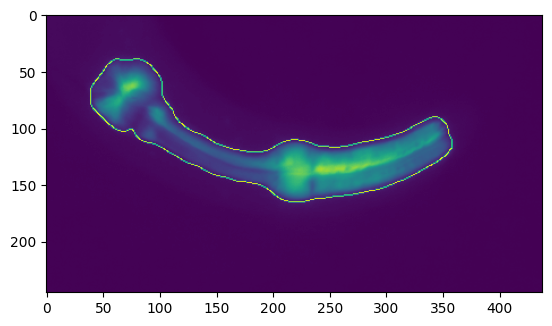

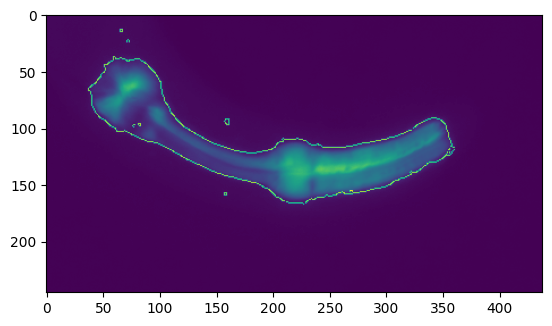

In [20]:
clf = xgb.Booster()
clf.load_model("./trained_model.json")

random.seed(1)
testing_set = random.sample(images, 100)

def predict_mask(img, classifier):
    features = extract_features_pytorch(img, model, shapes, device)

    features = torch.flatten(features, start_dim=0, end_dim=1)
    print(features.shape)

    X = xgb.DMatrix(features.cpu().numpy())

    prediction = (clf.predict(X)>0.5).astype(int)

    prediction = prediction.reshape(img.shape[0], img.shape[1])

    return prediction

def get_bbox(mask, expand=40):
    try:
        # Find the non-zero pixels in the mask
        y_coords, x_coords = np.nonzero(mask)

        # Calculate the minimum and maximum x and y coordinates
        y_min, y_max = np.min(y_coords), np.max(y_coords)
        x_min, x_max = np.min(x_coords), np.max(x_coords)

        # Expand the bounding box by the specified amount
        y_min -= expand
        x_min -= expand
        height = y_max - y_min + 2 * expand
        width = x_max - x_min + 2 * expand

        return [[y_min, x_min], width, height]
    except ValueError:
        return [[1000, 1000], 10, 10]

img_path = testing_set[50]
ground_truth_path = img_path.replace('ch1/', 'ch1_il/seg_')
img = image_handling.read_tiff_file(img_path)
img = normalize(img,1,99.8,axis=(0,1))
img = image_handling.normalize_image(img, np.uint8)

ground_truth = image_handling.read_tiff_file(ground_truth_path).astype(np.uint8)
prediction = predict_mask(img, clf)
prediction = cv2.medianBlur(prediction.astype(np.uint8), 9)

bbox = get_bbox(prediction, expand=40)

p = prediction[bbox[0][0]:bbox[0][0]+bbox[2], bbox[0][1]:bbox[0][1]+bbox[1]]
i = img[bbox[0][0]:bbox[0][0]+bbox[2], bbox[0][1]:bbox[0][1]+bbox[1]]
g = ground_truth[bbox[0][0]:bbox[0][0]+bbox[2], bbox[0][1]:bbox[0][1]+bbox[1]]

# get the outline of the biggest object
outline = cv2.Canny(p.astype(np.uint8), 0, 1) > 0
outline_g = cv2.Canny(g.astype(np.uint8), 0, 1) > 0


plt.imshow(i/i.max() + outline)
plt.show()

plt.imshow(i/i.max() + outline_g)
plt.show()